In [13]:
import pandas as pd  # Import Pandas for data handling

# Define the file path where the dataset is stored
file_path = "/content/FY_2024_Hospital_Readmissions_Reduction_Program_Hospital.csv"

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(file_path)

# Quick check: Display the first few rows to understand the structure
df.head()


,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HIP-KNEE-HRRP,NaN,NaN,0.8916,3.5325,3.9618,Too Few to Report,07/01/2019,06/30/2022
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HF-HRRP,616.0,NaN,1.1003,23.1263,21.0184,149,07/01/2019,06/30/2022
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-AMI-HRRP,274.0,NaN,0.9332,12.9044,13.8283,32,07/01/2019,06/30/2022
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-PN-HRRP,404.0,NaN,0.9871,17.0529,17.2762,68,07/01/2019,06/30/2022
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-CABG-HRRP,126.0,NaN,0.9517,9.8131,10.3112,11,07/01/2019,06/30/2022


In [14]:
# Check dataset structure, column names, and data types
df.info()

# Check missing values in each column
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18774 entries, 0 to 18773
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Facility Name               18774 non-null  object 
 1   Facility ID                 18774 non-null  int64  
 2   State                       18774 non-null  object 
 3   Measure Name                18774 non-null  object 
 4   Number of Discharges        8094 non-null   float64
 5   Footnote                    6697 non-null   float64
 6   Excess Readmission Ratio    12077 non-null  float64
 7   Predicted Readmission Rate  12077 non-null  float64
 8   Expected Readmission Rate   12077 non-null  float64
 9   Number of Readmissions      12077 non-null  object 
 10  Start Date                  18774 non-null  object 
 11  End Date                    18774 non-null  object 
dtypes: float64(5), int64(1), object(6)
memory usage: 1.7+ MB


,0
Facility Name,0
Facility ID,0
State,0
Measure Name,0
Number of Discharges,10680
Footnote,12077
Excess Readmission Ratio,6697
Predicted Readmission Rate,6697
Expected Readmission Rate,6697
Number of Readmissions,6697


In [15]:
from sklearn.impute import KNNImputer
import numpy as np

# Drop 'Footnote' since it's mostly missing
df.drop(columns=['Footnote'], inplace=True)

# Convert 'Number of Readmissions' to numeric, replacing "Too Few to Report" with NaN
df['Number of Readmissions'] = pd.to_numeric(df['Number of Readmissions'], errors='coerce')

# Apply KNN Imputation for missing values (better than mean/median fill)
imputer = KNNImputer(n_neighbors=5)
num_cols = ['Number of Discharges', 'Excess Readmission Ratio', 'Predicted Readmission Rate',
            'Expected Readmission Rate', 'Number of Readmissions']

df[num_cols] = imputer.fit_transform(df[num_cols])

# Drop rows where 'Excess Readmission Ratio' is still missing (target variable)
df.dropna(subset=['Excess Readmission Ratio'], inplace=True)

# Convert 'Start Date' & 'End Date' into separate Year and Month columns
df['Start Year'] = pd.to_datetime(df['Start Date']).dt.year
df['End Year'] = pd.to_datetime(df['End Date']).dt.year

# Drop original date columns
df.drop(columns=['Start Date', 'End Date'], inplace=True)

# Check if all missing values are handled
print("Missing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
Facility Name                 0
Facility ID                   0
State                         0
Measure Name                  0
Number of Discharges          0
Excess Readmission Ratio      0
Predicted Readmission Rate    0
Expected Readmission Rate     0
Number of Readmissions        0
Start Year                    0
End Year                      0
dtype: int64


In [17]:
!pip install category-encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.1 MB/s eta 0:00:00


In [18]:
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce  # For Target Encoding

# Apply Target Encoding for 'Facility Name' (Large number of categories)
target_enc = ce.TargetEncoder(cols=['Facility Name'])
df['Facility_Name_Enc'] = target_enc.fit_transform(df['Facility Name'], df['Excess Readmission Ratio'])

# Apply Label Encoding for 'State' (Convert to numerical categories)
le = LabelEncoder()
df['State_Enc'] = le.fit_transform(df['State'])

# Apply One-Hot Encoding for 'Measure Name'
df = pd.get_dummies(df, columns=['Measure Name'], drop_first=True)

# Drop original categorical columns
df.drop(columns=['Facility Name', 'State'], inplace=True)

# Show dataset after encoding
print("Updated dataset after encoding:")
print(df.head())


Updated dataset after encoding:
   Facility ID  Number of Discharges  Excess Readmission Ratio  \
0        10001                 568.8                    0.8916   
1        10001                 616.0                    1.1003   
2        10001                 274.0                    0.9332   
3        10001                 404.0                    0.9871   
4        10001                 126.0                    0.9517   

   Predicted Readmission Rate  Expected Readmission Rate  \
0                      3.5325                     3.9618   
1                     23.1263                    21.0184   
2                     12.9044                    13.8283   
3                     17.0529                    17.2762   
4                      9.8131                    10.3112   

   Number of Readmissions  Start Year  End Year  Facility_Name_Enc  State_Enc  \
0                    18.8        2019      2022           0.996783          1   
1                   149.0        2019      2022 

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the target variable (what we want to predict)
target_column = 'Excess Readmission Ratio'
X = df.drop(columns=[target_column])  # Features (independent variables)
y = df[target_column]  # Target (dependent variable)

# Split the data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize (normalize) the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the shapes of the training and test sets
print("Training Features Shape:", X_train.shape)
print("Test Features Shape:", X_test.shape)


Training Features Shape: (15019, 14)
Test Features Shape: (3755, 14)


In [20]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers

# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Train Ridge Regression (L2 Regularization)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Train Lasso Regression (L1 Regularization)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Train XGBoost Regression
xgb = XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.05)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Train a Neural Network
nn_model = tf.keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)  # Output layer
])
nn_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
nn_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
y_pred_nn = nn_model.predict(X_test).flatten()

# Function to evaluate models
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nModel: {model_name}")
    print(f"Mean Squared Error (MSE): {mse:.5f}")
    print(f"R-Squared Score (R²): {r2:.5f}")

# Evaluate all models
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Ridge Regression", y_test, y_pred_ridge)
evaluate_model("Lasso Regression", y_test, y_pred_lasso)
evaluate_model("XGBoost Regressor", y_test, y_pred_xgb)
evaluate_model("Neural Network", y_test, y_pred_nn)


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Model: Linear Regression
Mean Squared Error (MSE): 0.00067
R-Squared Score (R²): 0.82051

Model: Ridge Regression
Mean Squared Error (MSE): 0.00067
R-Squared Score (R²): 0.82060

Model: Lasso Regression
Mean Squared Error (MSE): 0.00372
R-Squared Score (R²): -0.00051

Model: XGBoost Regressor
Mean Squared Error (MSE): 0.00018
R-Squared Score (R²): 0.95219

Model: Neural Network
Mean Squared Error (MSE): 0.00009
R-Squared Score (R²): 0.97474


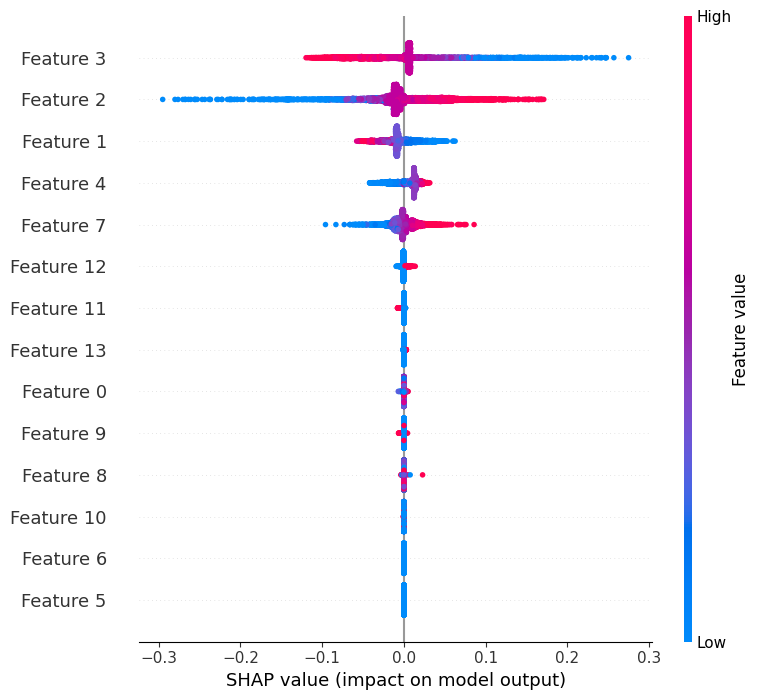

In [21]:
import shap

# Explain the XGBoost model
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Summary plot to show feature importance
shap.summary_plot(shap_values, X_test)


In [22]:
import joblib

# Save the cleaned dataset
df.to_csv('cleaned_hospital_readmissions.csv', index=False)

# Save the XGBoost model
joblib.dump(xgb, 'xgboost_model.pkl')

# Save the Neural Network model
nn_model.save('neural_network_model.h5')

print("Dataset and models saved successfully!")


Dataset and models saved successfully!


In [23]:
# Saving the Neural Network in Keras format
nn_model.save('neural_network_model.keras')
print("Neural Network model saved in Keras format!")


Neural Network model saved in Keras format!


In [24]:
import os

# Create folders for GitHub structure
os.makedirs('Hospital-Readmission-Prediction/data', exist_ok=True)
os.makedirs('Hospital-Readmission-Prediction/models', exist_ok=True)
os.makedirs('Hospital-Readmission-Prediction/notebooks', exist_ok=True)

# Move files into the appropriate folders
!mv cleaned_hospital_readmissions.csv Hospital-Readmission-Prediction/data/
!mv xgboost_model.pkl Hospital-Readmission-Prediction/models/
!mv neural_network_model.h5 Hospital-Readmission-Prediction/models/


In [25]:
# Generate dependencies file
!pip freeze > Hospital-Readmission-Prediction/requirements.txt


In [30]:
!git add .
!git commit -m "Initial commit - Added hospital readmission project files"


[main (root-commit) 958c1ea] Initial commit - Added hospital readmission project files
 4 files changed, 19335 insertions(+)
 create mode 100644 data/cleaned_hospital_readmissions.csv
 create mode 100644 models/neural_network_model.h5
 create mode 100644 models/xgboost_model.pkl
 create mode 100644 requirements.txt


In [39]:
!git push -u origin main


Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 609.01 KiB | 3.09 MiB/s, done.
Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/hrithikda/Hospital-Readmission-Prediction.git
 * [new branch]      main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.
